In [3]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt

np.random.seed(17)
%matplotlib inline

In [ ]:
import torch

import torch.nn as nn
import torch.nn.functional as F

torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

In [5]:
from sklearn.cluster import KMeans
from torch.nn.modules.loss import _Loss
from torch.autograd import Variable
from torch.utils.data import Dataset


def gen_mask(ins_img):
    mask = []
    for i, mask_i in enumerate(ins_img):
        binarized = mask_i * (i + 1)
        mask.append(binarized)
    mask = np.sum(np.stack(mask, axis=0), axis=0).astype(np.uint8)
    return mask


def coloring(mask):
    ins_color_img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    n_ins = len(np.unique(mask)) - 1
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, n_ins)]
    for i in range(n_ins):
        ins_color_img[mask == i + 1] =\
            (np.array(colors[i][:3]) * 255).astype(np.uint8)
    return ins_color_img


def gen_instance_mask(sem_pred, ins_pred, n_obj):
    embeddings = ins_pred[:, sem_pred].transpose(1, 0)
    clustering = KMeans(n_obj).fit(embeddings)
    labels = clustering.labels_

    instance_mask = np.zeros_like(sem_pred, dtype=np.uint8)
    for i in range(n_obj):
        lbl = np.zeros_like(labels, dtype=np.uint8)
        lbl[labels == i] = i + 1
        instance_mask[sem_pred] += lbl

    return instance_mask


def gen_color_img(sem_pred, ins_pred, n_obj):
    return coloring(gen_instance_mask(sem_pred, ins_pred, n_obj))


"""
This implementation is based on following code:
https://github.com/milesial/Pytorch-UNet
"""

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        else:
            self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # self.conv = nn.Conv2d(in_ch, out_ch, 1)
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, in_ch//2, 1),
            nn.BatchNorm2d(in_ch//2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch//2, out_ch, 1),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.inc = inconv(1, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.sem_out = outconv(64, 2)
        self.ins_out = outconv(64, 16)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        sem = self.sem_out(x)
        ins = self.ins_out(x)
        return sem, ins

class DiscriminativeLoss(_Loss):

    def __init__(self, delta_var=0.5, delta_dist=1.5,
                 norm=2, alpha=1.0, beta=1.0, gamma=0.001,
                 usegpu=True, size_average=True):
        super(DiscriminativeLoss, self).__init__(size_average)
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.usegpu = usegpu
        assert self.norm in [1, 2]

    def forward(self, input, target, n_clusters):
        return self._discriminative_loss(input, target, n_clusters)

    def _discriminative_loss(self, input, target, n_clusters):
        bs, n_features, height, width = input.size()
        max_n_clusters = target.size(1)

        input = input.contiguous().view(bs, n_features, height * width)
        target = target.contiguous().view(bs, max_n_clusters, height * width)

        c_means = self._cluster_means(input, target, n_clusters)
        l_var = self._variance_term(input, target, c_means, n_clusters)
        l_dist = self._distance_term(c_means, n_clusters)
        l_reg = self._regularization_term(c_means, n_clusters)

        loss = self.alpha * l_var + self.beta * l_dist + self.gamma * l_reg

        return loss

    def _cluster_means(self, input, target, n_clusters):
        bs, n_features, n_loc = input.size()
        max_n_clusters = target.size(1)

        # bs, n_features, max_n_clusters, n_loc
        input = input.unsqueeze(2).expand(bs, n_features, max_n_clusters, n_loc)
        # bs, 1, max_n_clusters, n_loc
        target = target.unsqueeze(1)
        # bs, n_features, max_n_clusters, n_loc
        input = input * target

        means = []
        for i in range(bs):
            # n_features, n_clusters, n_loc
            input_sample = input[i, :, :n_clusters[i]]
            # 1, n_clusters, n_loc,
            target_sample = target[i, :, :n_clusters[i]]
            # n_features, n_cluster
            mean_sample = input_sample.sum(2) / target_sample.sum(2)

            # padding
            n_pad_clusters = max_n_clusters - n_clusters[i]
            assert n_pad_clusters >= 0
            if n_pad_clusters > 0:
                pad_sample = torch.zeros(n_features, n_pad_clusters)
                pad_sample = Variable(pad_sample)
                if self.usegpu:
                    pad_sample = pad_sample.cuda()
                mean_sample = torch.cat((mean_sample, pad_sample), dim=1)
            means.append(mean_sample)

        # bs, n_features, max_n_clusters
        means = torch.stack(means)

        return means

    def _variance_term(self, input, target, c_means, n_clusters):
        bs, n_features, n_loc = input.size()
        max_n_clusters = target.size(1)

        # bs, n_features, max_n_clusters, n_loc
        c_means = c_means.unsqueeze(3).expand(bs, n_features, max_n_clusters, n_loc)
        # bs, n_features, max_n_clusters, n_loc
        input = input.unsqueeze(2).expand(bs, n_features, max_n_clusters, n_loc)
        # bs, max_n_clusters, n_loc
        var = (torch.clamp(torch.norm((input - c_means), self.norm, 1) -
                           self.delta_var, min=0) ** 2) * target

        var_term = 0
        for i in range(bs):
            # n_clusters, n_loc
            var_sample = var[i, :n_clusters[i]]
            # n_clusters, n_loc
            target_sample = target[i, :n_clusters[i]]

            # n_clusters
            c_var = var_sample.sum(1) / target_sample.sum(1)
            var_term += c_var.sum() / n_clusters[i]
        var_term /= bs

        return var_term

    def _distance_term(self, c_means, n_clusters):
        bs, n_features, max_n_clusters = c_means.size()

        dist_term = 0
        for i in range(bs):
            if n_clusters[i] <= 1:
                continue

            # n_features, n_clusters
            mean_sample = c_means[i, :, :n_clusters[i]]

            # n_features, n_clusters, n_clusters
            means_a = mean_sample.unsqueeze(2).expand(n_features, n_clusters[i], n_clusters[i])
            means_b = means_a.permute(0, 2, 1)
            diff = means_a - means_b

            margin = 2 * self.delta_dist * (1.0 - torch.eye(n_clusters[i]))
            margin = Variable(margin)
            if self.usegpu:
                margin = margin.cuda()
            c_dist = torch.sum(torch.clamp(margin - torch.norm(diff, self.norm, 0), min=0) ** 2)
            dist_term += c_dist / (2 * n_clusters[i] * (n_clusters[i] - 1))
        dist_term /= bs

        return dist_term

    def _regularization_term(self, c_means, n_clusters):
        bs, n_features, max_n_clusters = c_means.size()

        reg_term = 0
        for i in range(bs):
            # n_features, n_clusters
            mean_sample = c_means[i, :, :n_clusters[i]]
            reg_term += torch.mean(torch.norm(mean_sample, self.norm, 0))
        reg_term /= bs

        return reg_term

class SSSDataset(Dataset):
    def __init__(self, train, n_sticks=8, data_size=512):
        super().__init__()
        self.train = train
        self.n_sticks = n_sticks
        self.data_size = data_size
        self.height = 256
        self.width = 256

    def __len__(self):
        return self.data_size

    def __getitem__(self, index):
        while True:
            img = np.ones((self.height, self.width), dtype=np.uint8) * 255
            ins = np.zeros((0, self.height, self.width), dtype=np.uint8)
            for _ in range(self.n_sticks):
                x = np.random.randint(30, 225)
                y = np.random.randint(30, 225)
                w = 15
                h = np.random.randint(80, 100)
                theta = np.random.randint(-90, 90)
                rect = ([x, y], [w, h], theta)
                box = np.int0(cv2.boxPoints(rect))

                gt = np.zeros_like(img)
                gt = cv2.fillPoly(gt, [box], 1)
                ins[:, gt != 0] = 0
                ins = np.concatenate([ins, gt[np.newaxis]])
                img = cv2.fillPoly(img, [box], 255)
                img = cv2.drawContours(img, [box], 0, 0, 2)

            # minimum area of stick
            if np.sum(np.sum(ins, axis=(1, 2)) < 400) == 0:
                break

        if self.train:
            sem = np.zeros_like(img, dtype=bool)
            sem[np.sum(ins, axis=0) != 0] = True
            sem = np.stack([~sem, sem]).astype(np.uint8)

            # 1 * height * width
            img = torch.Tensor(img[np.newaxis])
            # 2 * height * width
            sem = torch.Tensor(sem)
            # n_sticks * height * width
            ins = torch.Tensor(ins)
            return img, sem, ins
        else:
            # 1 * height * width
            img = torch.Tensor(img[np.newaxis])
            return img




In [6]:
n_sticks = 8
height = 256
width = 256

while True:
    img = np.ones((height, width), dtype=np.uint8) * 255
    ins = np.zeros((0, height, width), dtype=np.uint8)
    for _ in range(n_sticks):
        x = np.random.randint(30, 225)
        y = np.random.randint(30, 225)
        w = 15
        h = np.random.randint(80, 100)
        theta = np.random.randint(-90, 90)
        rect = ([x, y], [w, h], theta)
        box = np.int0(cv2.boxPoints(rect))

        gt = np.zeros_like(img)
        gt = cv2.fillPoly(gt, [box], 1)
        ins[:, gt != 0] = 0
        ins = np.concatenate([ins, gt[np.newaxis]])
        img = cv2.fillPoly(img, [box], 255)
        img = cv2.drawContours(img, [box], 0, 0, 2)

    if np.sum(np.sum(ins, axis=(1, 2)) < 400) == 0:
        break

# New Section

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 15))
plt.gray()

axes[0].imshow(img)
axes[1].imshow(np.sum(ins, axis=0))
axes[2].imshow(coloring(gen_mask(ins)))


In [ ]:
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable

print('import done')

In [9]:
n_sticks = 8

In [10]:
# Model
model = UNet().to(device)

In [11]:
# Dataset for train
train_dataset = SSSDataset(train=True, n_sticks=n_sticks)
train_dataloader = DataLoader(train_dataset, batch_size=1,
                              shuffle=False, num_workers=0, pin_memory=True)

print(len(train_dataset))

512


In [12]:
# Dataset for inference
# Change to standard dataset if normal images wanted, rotated_90 if 1 image with 1 90-degree rotated copy
test_dataset = SSSDataset(train=True, n_sticks=n_sticks, data_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=1,
                             shuffle=False, num_workers=0,
                             pin_memory=True)

In [ ]:
# Loss Function
criterion_disc = DiscriminativeLoss(delta_var=0.5,
                                    delta_dist=1.5,
                                    norm=2,
                                    usegpu=True)
criterion_ce = nn.CrossEntropyLoss()

In [14]:

# Optimizer
parameters = model.parameters()
optimizer = optim.SGD(parameters, lr=0.01, momentum=0.9, weight_decay=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min',
                                                 factor=0.1,
                                                 patience=10,
                                                 verbose=True)

In [ ]:
# Train
from scipy import ndimage as ndi

model.train()
model_dir = Path('/content/gdrive/MyDrive/Colab_Notebooks/pytorch-discriminative-loss-master/model')
sys.path.append('/content/gdrive/MyDrive/Colab_Notebooks/pytorch-discriminative-loss-master/model')
sys.path.append('/content/gdrive/MyDrive/Colab_Notebooks/pytorch-discriminative-loss-master/model.pth')
best_loss = np.inf
for epoch in range(2):#originally 300
    print(f'epoch : {epoch}')
    disc_losses = []
    ce_losses = []
    i=0
    dice_complete = 0

    sem_pred_eval = []
    ins_pred_eval = []
    p_sem_pred_eval = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    for batched in train_dataloader:
        
        #print(f'batched : {batched}')
        images, sem_labels, ins_labels = batched
        images = Variable(images)
        sem_labels = Variable(sem_labels)
        ins_labels = Variable(ins_labels)

        images = images.to(device)
        sem_labels = sem_labels.to(device)
        ins_labels = ins_labels.to(device)

        model.zero_grad()

        sem_predict, ins_predict = model(images)
        if i == 0:
          sem_pred_eval.append(F.softmax(sem_predict, dim=1).cpu().data.numpy())
          ins_pred_eval.append(ins_predict.cpu().data.numpy())
          sem_pred_eval = np.concatenate(sem_pred_eval)[:, 1, :, :]
          ins_pred_eval = np.concatenate(ins_pred_eval)

        loss = 0

        # Discriminative Loss
        disc_loss = criterion_disc(ins_predict,
                                   ins_labels,
                                   [n_sticks] * len(images))
        loss += disc_loss

        disc_losses.append(disc_loss.cpu().data.numpy())

        # Cross Entropy Loss
        _, sem_labels_ce = sem_labels.max(1)
        ce_loss = criterion_ce(sem_predict.permute(0, 2, 3, 1)\
                                   .contiguous().view(-1, 2),
                               sem_labels_ce.view(-1))
        loss += ce_loss
        ce_losses.append(ce_loss.cpu().data.numpy())

        loss.backward()
        optimizer.step()

        # Evaluation by DICE score

        if i == 0:
          p_sem_pred_eval.append(ndi.morphology.binary_fill_holes(sem_pred_eval[0] > 0.5))
          pred_eval = gen_color_img(p_sem_pred_eval[0], ins_pred_eval[0], n_sticks)
          groundtruth_eval = coloring(gen_mask(ins_labels[0].cpu()))

          pred_eval = pred_eval[:,:,1] #I have checked that no two colors have the same values in this channel. They are: 232, 81, 159, 1, 217, 79, 247, 165
          groundtruth_eval = groundtruth_eval[:,:,1]

          dice_total = 0
          colors_pred = [232, 81, 159, 1, 217, 79, 247, 165]
          colors_gt = [232, 81, 159, 1, 217, 79, 247, 165]

          for y in range(1,8):
            a = np.array(groundtruth_eval==colors_gt[0]).astype(int)
            Area_GT = np.count_nonzero(a)
            Overlap = 0
            for x in colors_pred:
               b = np.array(pred_eval==x).astype(int)
               Overlap_temp = np.count_nonzero(np.multiply(a,b))*2
               if (Overlap_temp > Overlap):
                  Overlap = Overlap_temp
                  x_temp = x
                  Area_Pred = np.count_nonzero(b)
            if (Overlap > 0):     #If no match, keep all the predicted sticks. One of them might match another ground truth.
              colors_pred.remove(x_temp)
            del colors_gt[0]
            dice_temp = Overlap / ((Area_GT)+(Area_Pred))
            dice_total = dice_total+dice_temp 

          #background
          a = np.array(groundtruth_eval==0).astype(int)
          Area_GT = np.count_nonzero(a)
          b = np.array(pred_eval==0).astype(int)
          Overlap = np.count_nonzero(np.multiply(a,b))*2
          Area_Pred = np.count_nonzero(b)
          dice_background = Overlap / ((Area_GT)+(Area_Pred))
          dice_total = dice_total+dice_background 
    
          print('Total Dice similarity score is {}'.format(dice_total/9))
          dice_complete = dice_complete + dice_total/9

        i=i+1

    disc_loss = np.mean(disc_losses)
    ce_loss = np.mean(ce_losses)
    print(f'DiscriminativeLoss: {disc_loss:.4f}')
    print(f'CrossEntropyLoss: {ce_loss:.4f}')
    scheduler.step(disc_loss)
    if disc_loss < best_loss:
        best_loss = disc_loss


    # Inference
    device = torch.device('cpu')
    model = model.to(device)

    ins_labels_test_all = []
    images = []
    sem_pred = []
    ins_pred = []

    for images_ in test_dataloader:
      images_test, sem_labels_test, ins_labels_test = images_
      ins_labels_test_all.append(coloring(gen_mask(ins_labels_test[0])))

      images.append(images_test.numpy())
    
      with torch.no_grad():
        sem_pred_, ins_pred_ = model(images_test)
        sem_pred.append(F.softmax(sem_pred_, dim=1).cpu().data.numpy())
        ins_pred.append(ins_pred_.cpu().data.numpy())

    images = np.concatenate(images)[:, 0].astype(np.uint8)
    sem_pred = np.concatenate(sem_pred)[:, 1, :, :]
    ins_pred = np.concatenate(ins_pred)

    # Post Processing
    p_sem_pred = []
    for sp in sem_pred:
      p_sem_pred.append(ndi.morphology.binary_fill_holes(sp > 0.5))

    # Evaluation by DICE score

    dice_complete = 0
    Area_GT=0
    Area_Pred=0
    Overlap_temp=0
    dice_background=0
    dice_temp=0
    x=0
    x_temp=0
    for i in range(0, 16):
      pred = gen_color_img(p_sem_pred[i], ins_pred[i], n_sticks)
      groundtruth = ins_labels_test_all[i]

      pred = pred[:,:,1] #I have checked that no two colors have the same values in this channel. They are: 232, 81, 159, 1, 217, 79, 247, 165
      groundtruth = groundtruth[:,:,1]

      dice_total = 0
      colors_pred = [232, 81, 159, 1, 217, 79, 247, 165]
      colors_gt = [232, 81, 159, 1, 217, 79, 247, 165]

      for y in range(1,8):
        a = np.array(groundtruth==colors_gt[0]).astype(int)
        Area_GT = np.count_nonzero(a)
        Overlap = 0
        for x in colors_pred:
          b = np.array(pred==x).astype(int)
          Overlap_temp = np.count_nonzero(np.multiply(a,b))*2
          if (Overlap_temp > Overlap):
            Overlap = Overlap_temp
            x_temp = x
            Area_Pred = np.count_nonzero(b)
        if (Overlap > 0):     #If no match, keep all the predicted sticks. One of them might match another ground truth.
            colors_pred.remove(x_temp)
        del colors_gt[0]
        dice_temp = Overlap / ((Area_GT)+(Area_Pred))
        dice_total = dice_total+dice_temp 

      #background
      a = np.array(groundtruth==0).astype(int)
      Area_GT = np.count_nonzero(a)
      b = np.array(pred==0).astype(int)
      Overlap = np.count_nonzero(np.multiply(a,b))*2
      Area_Pred = np.count_nonzero(b)
      dice_background = Overlap / ((Area_GT)+(Area_Pred))
      dice_total = dice_total+dice_background 
    
      dice_complete = dice_complete + dice_total/9

    print('Test set: Complete Dice similarity score is {}'.format(dice_complete/16))

  

In [16]:
from scipy import ndimage as ndi

np.random.seed(0)

In [17]:
n_sticks = 8

In [18]:
# Model
model.eval()

device = torch.device('cpu')
model = model.to(device)

In [ ]:
# Inference
device = torch.device('cpu')
model = model.to(device)

ins_labels_test_all = []
images = []
sem_pred = []
ins_pred = []

for images_ in test_dataloader:
    images_test, sem_labels_test, ins_labels_test = images_
    ins_labels_test_all.append(coloring(gen_mask(ins_labels_test[0])))

    images.append(images_test.numpy())
    
    with torch.no_grad():
        sem_pred_, ins_pred_ = model(images_test)
        sem_pred.append(F.softmax(sem_pred_, dim=1).cpu().data.numpy())
        ins_pred.append(ins_pred_.cpu().data.numpy())

images = np.concatenate(images)[:, 0].astype(np.uint8)
sem_pred = np.concatenate(sem_pred)[:, 1, :, :]
ins_pred = np.concatenate(ins_pred)


In [20]:
# Post Processing
p_sem_pred = []
for sp in sem_pred:
    p_sem_pred.append(ndi.morphology.binary_fill_holes(sp > 0.5))

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
plt.gray()

for i, ax_ in enumerate(axes):
    color_img = gen_color_img(p_sem_pred[i], ins_pred[i], n_sticks)
    ax_[0].imshow(images[i])
    ax_[1].imshow(~p_sem_pred[i])
    ax_[2].imshow(color_img)

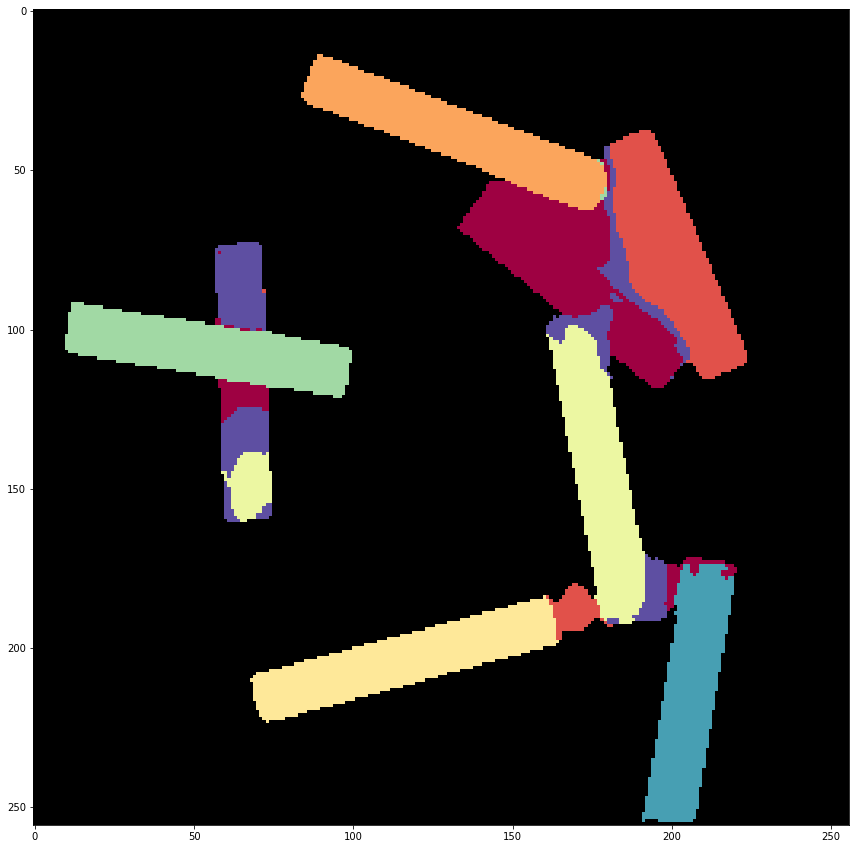

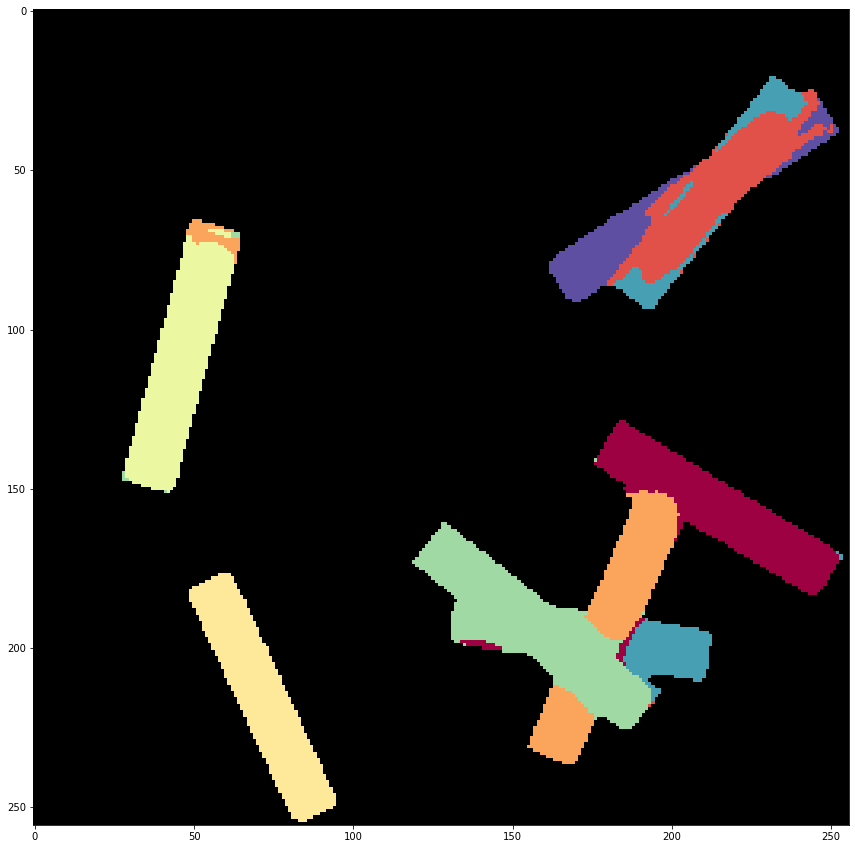

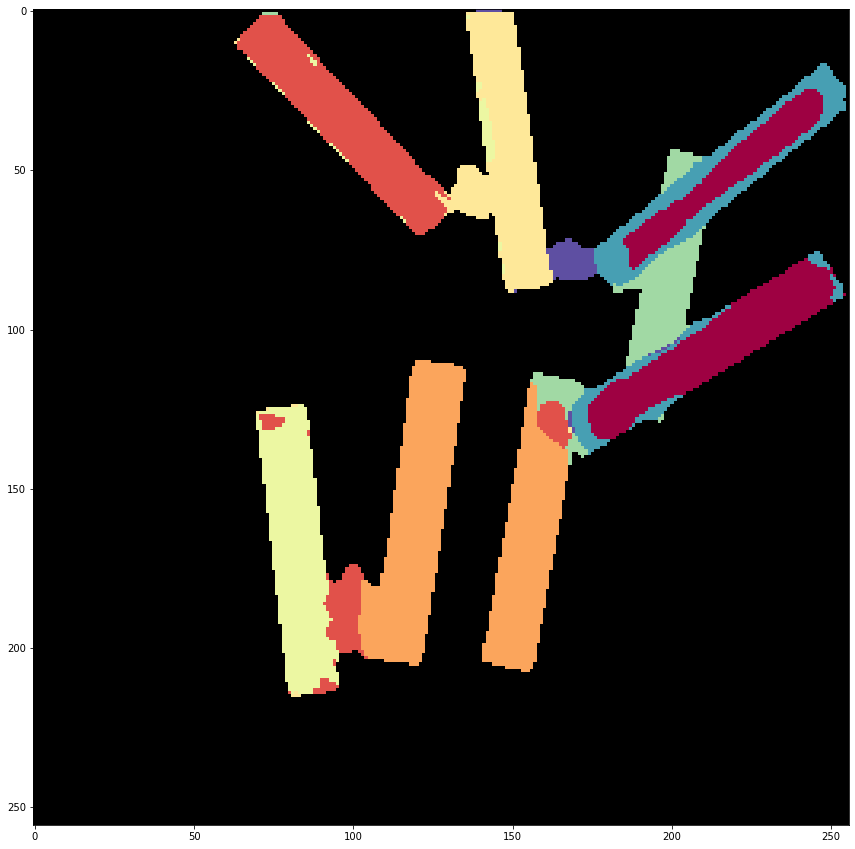

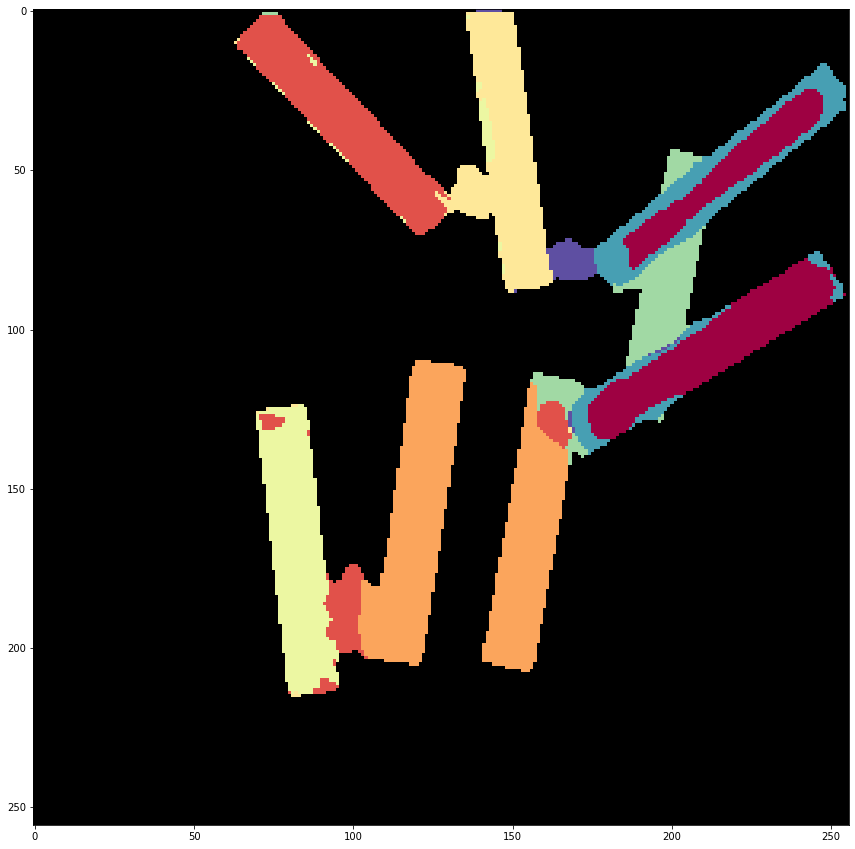

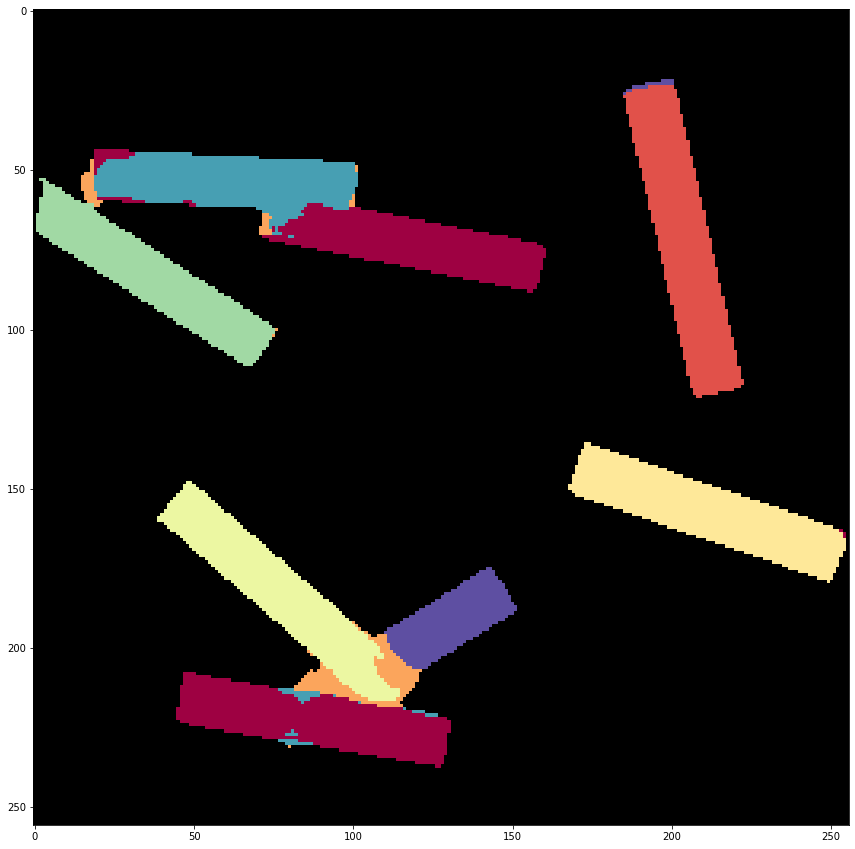

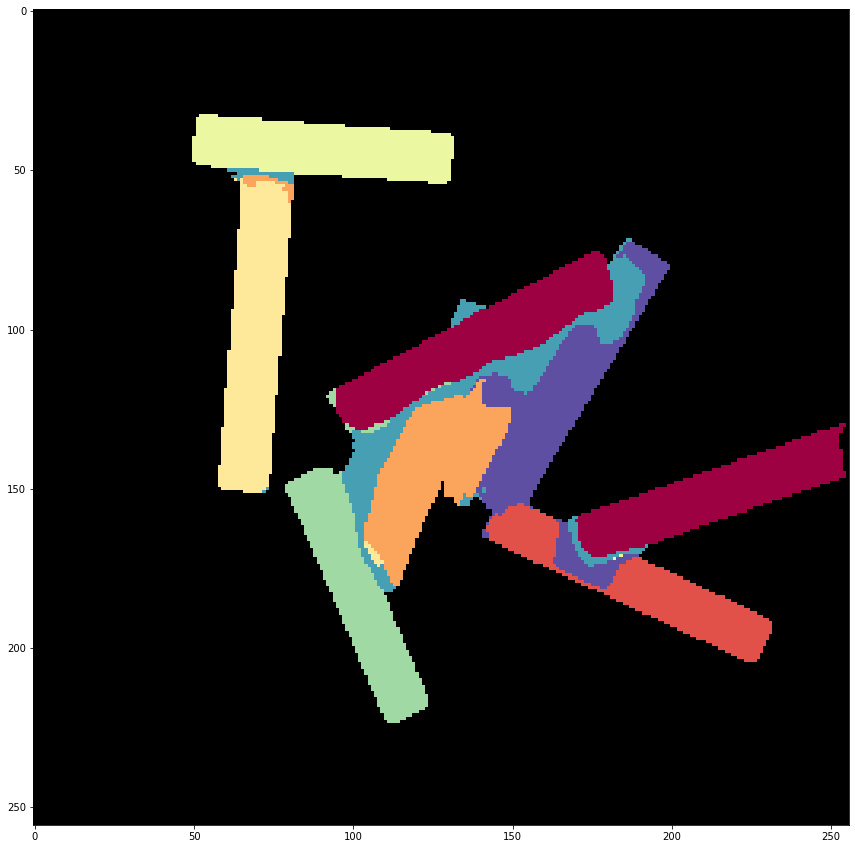

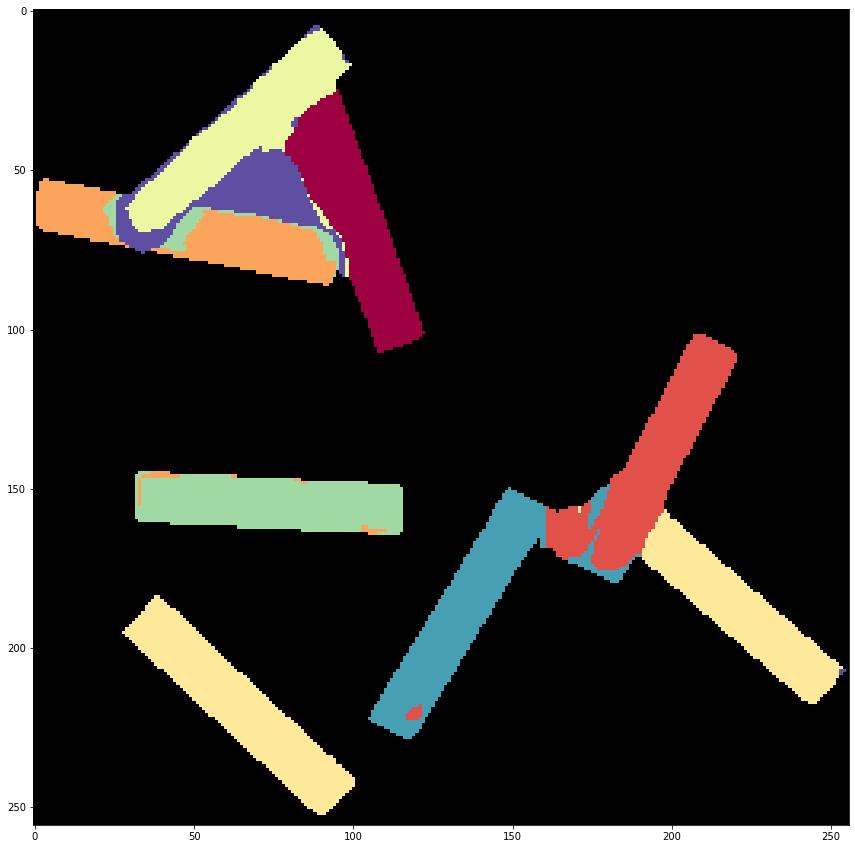

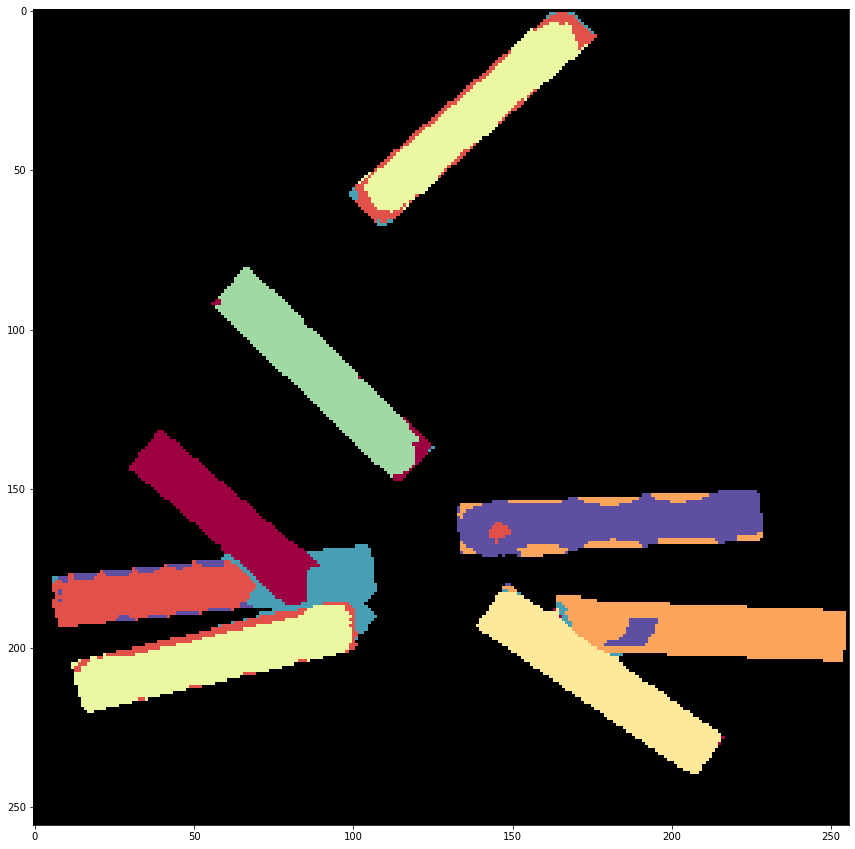

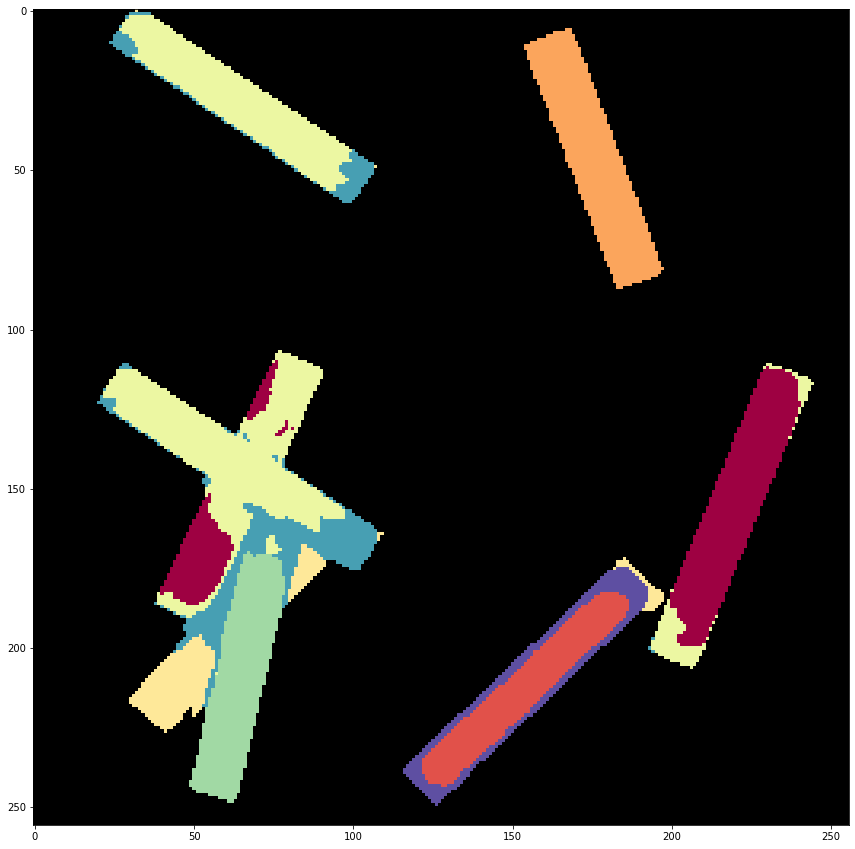

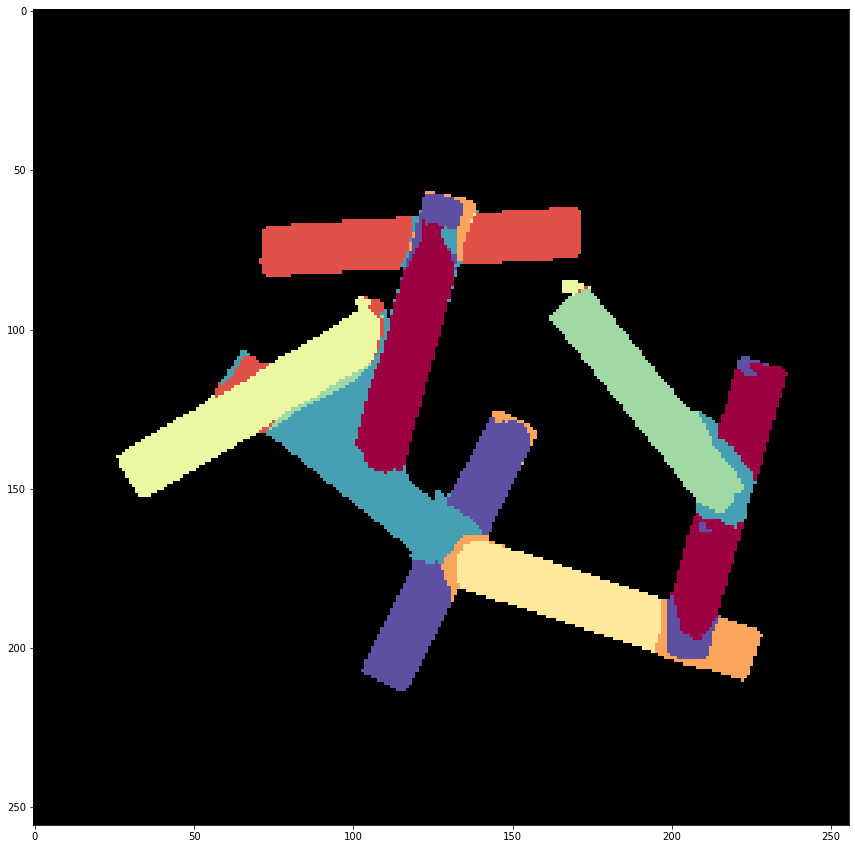

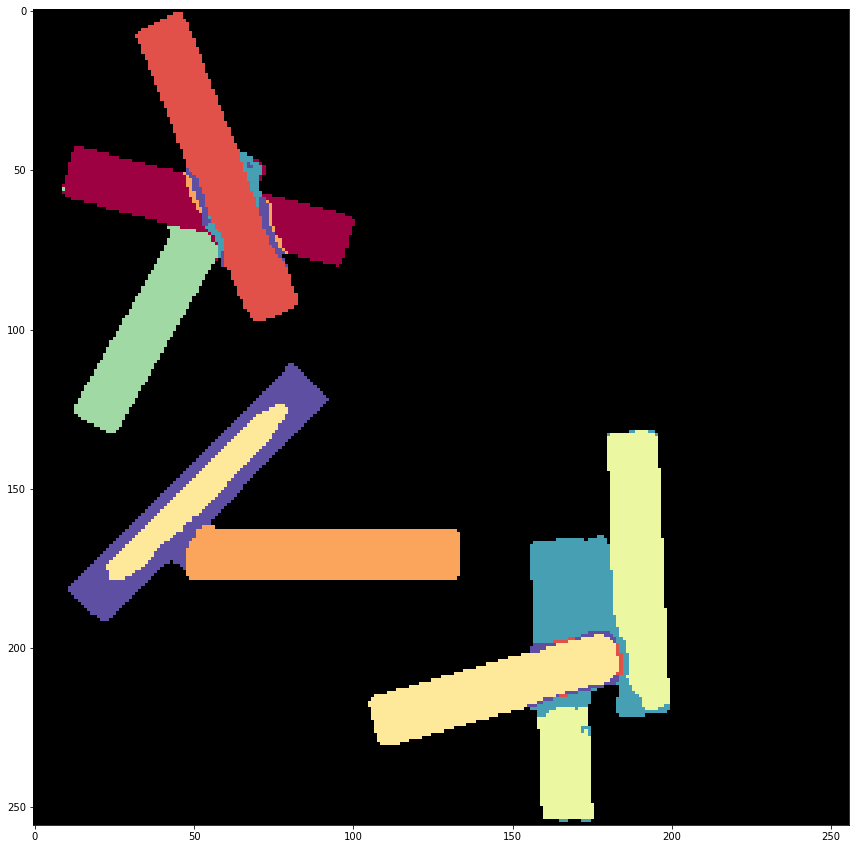

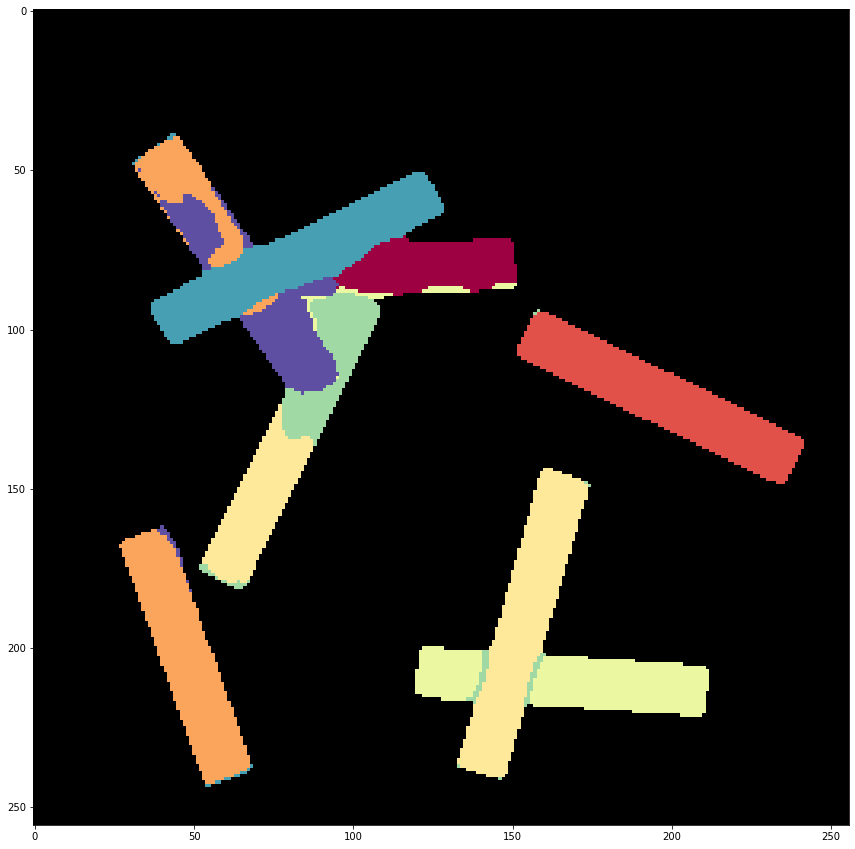

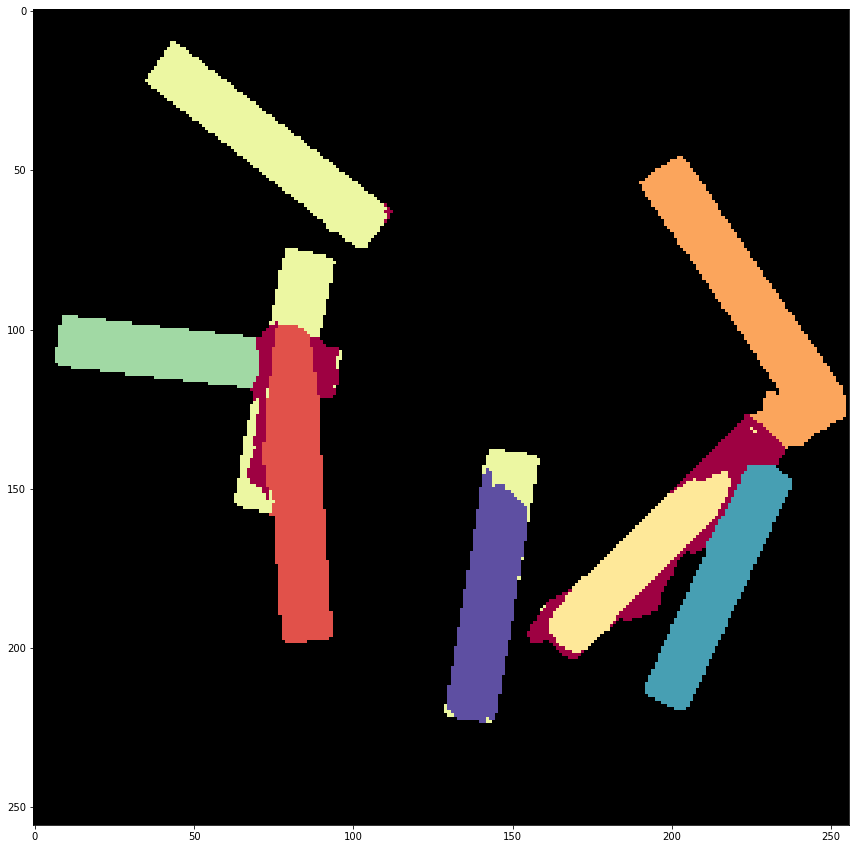

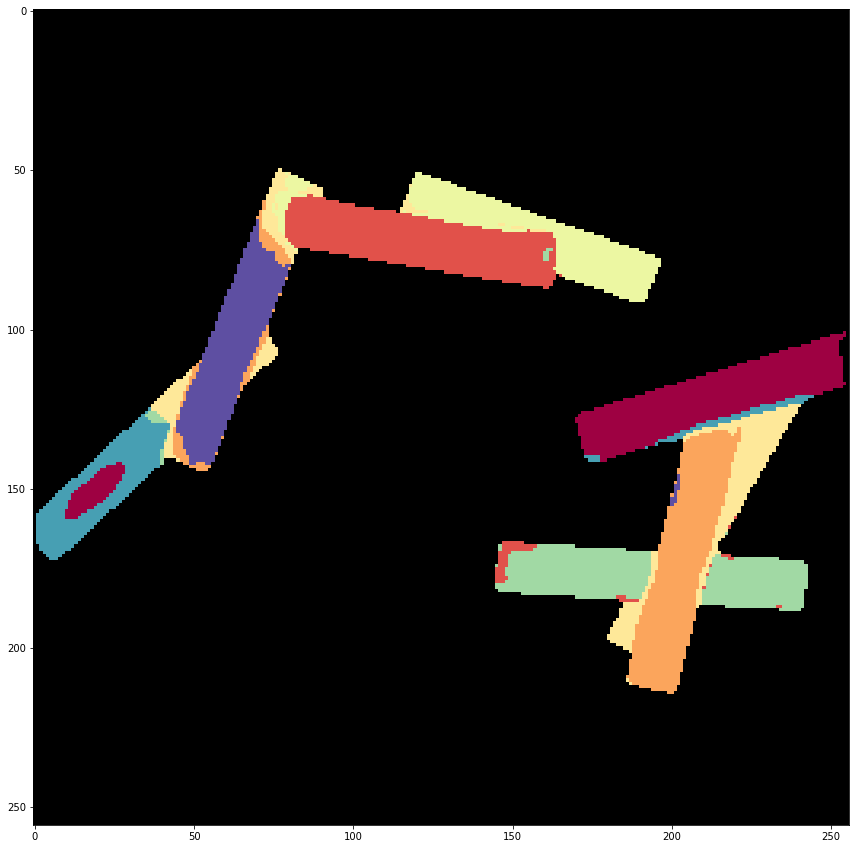

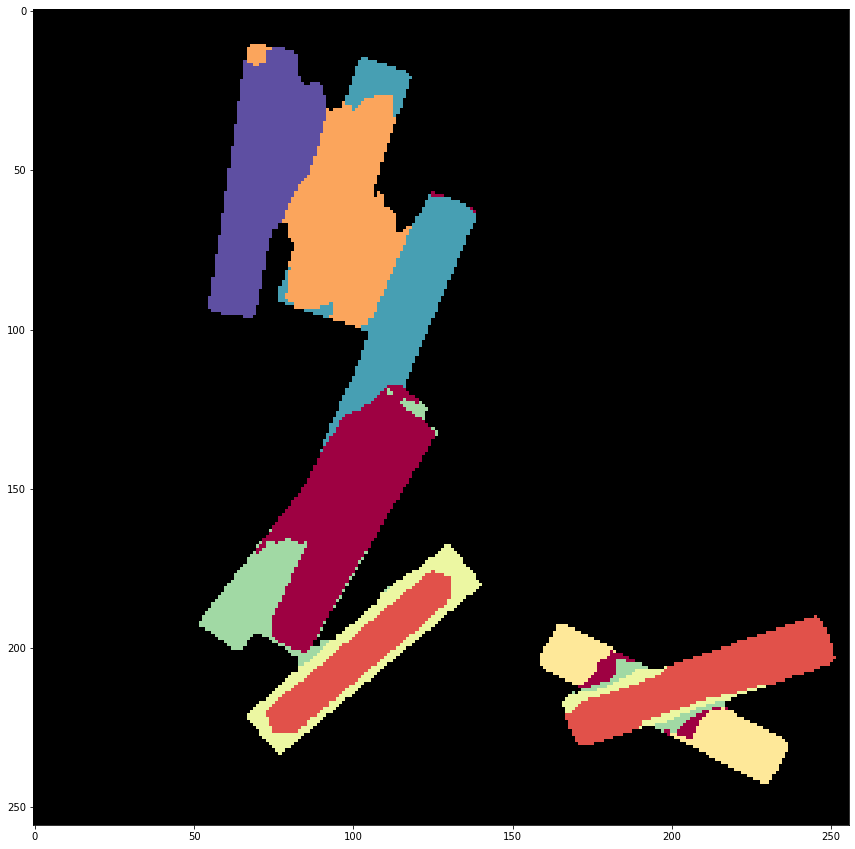

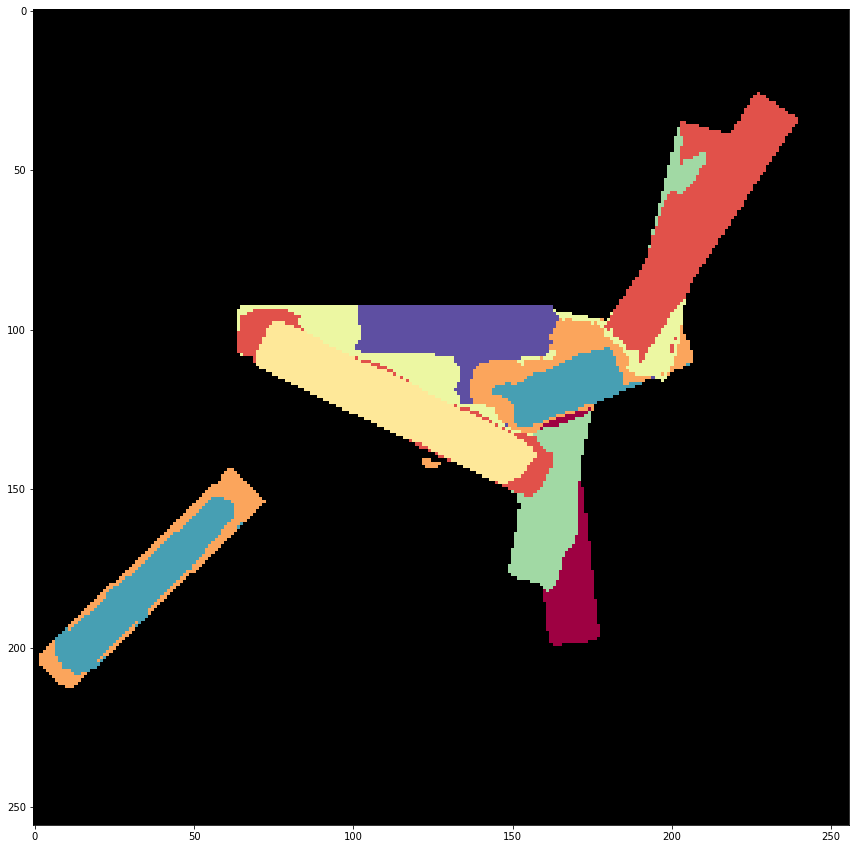

In [22]:
#This one for a single image

fig, axes = plt.subplots(figsize=(15, 15))
plt.gray()

color_img = gen_color_img(p_sem_pred[0], ins_pred[0], n_sticks)
axes.imshow(color_img)

fig2, axes2 = plt.subplots(figsize=(15, 15))
plt.gray()

color_img2 = gen_color_img(p_sem_pred[1], ins_pred[1], n_sticks)
axes2.imshow(color_img2)

fig3, axes3 = plt.subplots(figsize=(15, 15))
plt.gray()

color_img3 = gen_color_img(p_sem_pred[2], ins_pred[2], n_sticks)
axes3.imshow(color_img3)

fig4, axes4 = plt.subplots(figsize=(15, 15))
plt.gray()

color_img4 = gen_color_img(p_sem_pred[3], ins_pred[3], n_sticks)
axes4.imshow(color_img3)

fig5, axes5 = plt.subplots(figsize=(15, 15))
plt.gray()

color_img5 = gen_color_img(p_sem_pred[4], ins_pred[4], n_sticks)
axes5.imshow(color_img5)

fig6, axes6 = plt.subplots(figsize=(15, 15))
plt.gray()

color_img6 = gen_color_img(p_sem_pred[5], ins_pred[5], n_sticks)
axes6.imshow(color_img6)

fig7, axes7 = plt.subplots(figsize=(15, 15))
plt.gray()

color_img7 = gen_color_img(p_sem_pred[6], ins_pred[6], n_sticks)
axes7.imshow(color_img7)

fig8, axes8 = plt.subplots(figsize=(15, 15))
plt.gray()

color_img8 = gen_color_img(p_sem_pred[7], ins_pred[7], n_sticks)
axes8.imshow(color_img8)

fig9, axes9 = plt.subplots(figsize=(15, 15))
plt.gray()

color_img9 = gen_color_img(p_sem_pred[8], ins_pred[8], n_sticks)
axes9.imshow(color_img9)

fig10, axes10 = plt.subplots(figsize=(15, 15))
plt.gray()

color_img10 = gen_color_img(p_sem_pred[9], ins_pred[9], n_sticks)
axes10.imshow(color_img10)

fig11, axes11 = plt.subplots(figsize=(15, 15))
plt.gray()

color_img11 = gen_color_img(p_sem_pred[10], ins_pred[10], n_sticks)
axes11.imshow(color_img11)

fig12, axes12 = plt.subplots(figsize=(15, 15))
plt.gray()

color_img12 = gen_color_img(p_sem_pred[11], ins_pred[11], n_sticks)
axes12.imshow(color_img12)

fig13, axes13 = plt.subplots(figsize=(15, 15))
plt.gray()

color_img13 = gen_color_img(p_sem_pred[12], ins_pred[12], n_sticks)
axes13.imshow(color_img13)

fig14, axes14 = plt.subplots(figsize=(15, 15))
plt.gray()

color_img14 = gen_color_img(p_sem_pred[13], ins_pred[13], n_sticks)
axes14.imshow(color_img14)

fig15, axes15 = plt.subplots(figsize=(15, 15))
plt.gray()

color_img15 = gen_color_img(p_sem_pred[14], ins_pred[14], n_sticks)
axes15.imshow(color_img15)

fig16, axes16 = plt.subplots(figsize=(15, 15))
plt.gray()

color_img16 = gen_color_img(p_sem_pred[15], ins_pred[15], n_sticks)
axes16.imshow(color_img16)


In [ ]:
# Evaluation by DICE score

dice_complete = 0
for i in range(0, 16):
  pred = gen_color_img(p_sem_pred[i], ins_pred[i], n_sticks)
  groundtruth = ins_labels_test_all[i]

  pred = pred[:,:,1] #I have checked that no two colors have the same values in this channel. They are: 232, 81, 159, 1, 217, 79, 247, 165
  groundtruth = groundtruth[:,:,1]

  dice_total = 0
  colors_pred = [232, 81, 159, 1, 217, 79, 247, 165]
  colors_gt = [232, 81, 159, 1, 217, 79, 247, 165]

  # This is to fix the ground truth label, and compare with all the labels of the prediction.
  # Remove the label with highest overlap.
  # Compute Dice Score for this instance.
  # Continue until no more labels left.
  # Calculate background Dice.
  # Finally compute total Dice Score.
  for y in range(1,8):
    a = np.array(groundtruth==colors_gt[0]).astype(int)
    Area_GT = np.count_nonzero(a)
    Overlap = 0
    for x in colors_pred:
      b = np.array(pred==x).astype(int)
      Overlap_temp = np.count_nonzero(np.multiply(a,b))*2
      if (Overlap_temp > Overlap):
        Overlap = Overlap_temp
        x_temp = x
        Area_Pred = np.count_nonzero(b)
    if (Overlap > 0):     #If no match, keep all the predicted sticks. One of them might match another ground truth.
      colors_pred.remove(x_temp)
    del colors_gt[0]
    dice_temp = Overlap / ((Area_GT)+(Area_Pred))
    dice_total = dice_total+dice_temp 

  #background
  a = np.array(groundtruth==0).astype(int)
  Area_GT = np.count_nonzero(a)
  b = np.array(pred==0).astype(int)
  Overlap = np.count_nonzero(np.multiply(a,b))*2
  Area_Pred = np.count_nonzero(b)
  dice_background = Overlap / ((Area_GT)+(Area_Pred))
  dice_total = dice_total+dice_background 
    
  print('Total Dice similarity score is {}'.format(dice_total/9))
  dice_complete = dice_complete + dice_total/9

print('Complete Dice similarity score is {}'.format(dice_complete/16))








